# Recreating Zwift ride powerplot

Note:  The code for importing .fit files and converting to a pandas dataframe is from http://johannesjacob.com/analyze-your-cycling-data-python/.
To install the python packages, type 'pip install pandas numpy fitparse matplotlib tqdm' on the command line.


## Import .fit file and convert to pandas dataframe

In [3]:
import os
import datetime
from zipfile import ZipFile
from fitparse import FitFile    # https://github.com/dtcooper/python-fitparse
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from tqdm import tqdm
from smooth import smooth
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox, AnchoredText, AnchoredOffsetbox)
from matplotlib.text import Annotation


## Title of Streamlit app

In [4]:
st.title('Workout Graph in Zwift Style')

2022-10-15 16:50:31.059 
  command:

    streamlit run /Users/ginadurante/miniforge3/envs/py39/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

##  Obtain FTP value from user to determine workout zones in graph

In [5]:
# set up try / except loop:
n = 0
while n < 3: 
    try:
        ftp = int(input("Enter FTP in watts (whole numbers only):  "))
        print(f"\nYour FTP has been recorded as {ftp} watts.")
        break
    except ValueError:
        n += 1
        print("\nYour FTP value cannot contain letters, be left blank, or be entered as a decimal value. \n")


Enter FTP in watts (whole numbers only):  260

Your FTP has been recorded as 260 watts.


## Have user enter file name / upload file

In [9]:
# importing the zipfile module
from zipfile import ZipFile

filename = input("Type or copy/paste filename, including .fit or .zip extension:  ")

if filename.endswith('.zip'):
    file_endswith = ".fit"

    try:
        with ZipFile(filename, 'r') as zObject:
            for file in zObject.namelist():
                if file.endswith(file_endswith):
                    zObject.extract(file)
            print("Extracted all ", file_endswith)
            filename = file
            print(file)
    except:
        print("Invalid file")
    
        
fitfile = FitFile(filename)

Type or copy/paste filename, including .fit or .zip extension:  Marco-9709382084.zip
Extracted all  .fit
9709382084_ACTIVITY.fit


### From Johannes Jacob's blog post (http://johannesjacob.com/2019/03/13/analyze-your-cycling-data-python/):  
_"Now we are ready to import the workout file and transform the data into a 
pandas dataframe. Unfortunately we have to use an ugly hack with this "while" 
loop to avoid timing issues. Then we are looping through the file, append 
the records to a list and convert the list to a pandas dataframe."_

In [10]:
def parse_fitfile(uploaded_file):
    fitfile = FitFile(uploaded_file)
    while True:
        try:
            fitfile.messages
            break
        except KeyError:
            continue
    workout = []
    for record in fitfile.get_messages('record'):
        r = {}
        for record_data in record:
            r[record_data.name] = record_data.value
        workout.append(r)
    df = pd.DataFrame(workout)
    
    return df

In [11]:
df = parse_fitfile(filename)

In [12]:
df

,distance,enhanced_speed,heart_rate,left_pedal_smoothness,left_right_balance,left_torque_effectiveness,power,right_pedal_smoothness,right_torque_effectiveness,speed,...,cadence,fractional_cadence,left_pco,left_power_phase,left_power_phase_peak,right_pco,right_power_phase,right_power_phase_peak,unknown_108,unknown_90
0,0.25,0.252,62,NaN,171,NaN,0.0,NaN,NaN,0.252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.50,0.252,62,14.0,171,51.0,122.0,16.5,52.0,0.252,...,74.0,0.0,0.0,"(0.0, 16.87500026367188)","(7.031250109863283, 12.65625019775391)",0.0,"(0.0, 15.468750241699222)","(5.625000087890626, 11.250000175781253)",NaN,NaN
2,0.76,0.252,62,14.0,171,51.0,130.0,16.5,52.0,0.252,...,85.0,0.0,0.0,"(0.0, 156.09375243896488)","(53.43750083496095, 104.0625016259766)",0.0,"(357.1875055810548, 154.68750241699223)","(59.06250092285158, 109.68750171386722)",NaN,NaN
3,6.86,6.112,62,17.0,173,62.0,91.0,16.5,57.0,6.112,...,80.0,0.0,0.0,"(1.4062500219726566, 182.81250285644535)","(61.87500096679689, 116.7187518237305)",0.0,"(357.1875055810548, 154.68750241699223)","(59.06250092285158, 109.68750171386722)",NaN,NaN
4,13.14,6.280,62,17.0,191,62.0,130.0,16.5,57.0,6.280,...,80.0,0.0,0.0,"(0.0, 185.62500290039068)","(63.28125098876955, 119.5312518676758)",0.0,"(355.7812555590821, 182.81250285644535)","(64.68750101074221, 120.93750188964847)",1417.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,46694.07,0.000,87,NaN,NaN,NaN,0.0,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2688.0,0.0
5387,46694.07,0.000,86,NaN,NaN,NaN,0.0,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2688.0,0.0
5388,46694.07,0.000,85,NaN,NaN,NaN,0.0,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2688.0,0.0
5389,46694.07,0.000,86,NaN,NaN,NaN,0.0,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2688.0,0.0


##  Remove unnecessary columns and remove null values

In [13]:
def df_clean_trim(df):
    #Drop unnecessary columns
    df_cleaned = df[['heart_rate', 'power', 'timestamp']].copy()
    # Insert a column 'data_points' to enable selection of max hr and watts by index
    df_cleaned.insert(loc=0, column='data_points', value=np.arange(len(df)))
    df_cleaned.rename(columns = {'power':'watts'}, inplace = True)
    df_cleaned['watts'].fillna(0, inplace=True)
    df_cleaned['heart_rate'].fillna(0, inplace=True)

    return df_cleaned

In [14]:
df_cleaned = df_clean_trim(df)
df_cleaned

,data_points,heart_rate,watts,timestamp
0,0,62,0.0,2022-10-01 13:36:31
1,1,62,122.0,2022-10-01 13:36:32
2,2,62,130.0,2022-10-01 13:36:33
3,3,62,91.0,2022-10-01 13:36:34
4,4,62,130.0,2022-10-01 13:36:35
...,...,...,...,...
5386,5386,87,0.0,2022-10-01 15:07:04
5387,5387,86,0.0,2022-10-01 15:07:05
5388,5388,85,0.0,2022-10-01 15:07:06
5389,5389,86,0.0,2022-10-01 15:07:07


## Get date of workout and length of workout in seconds/minutes 

In [15]:
def workout_date_time_freq(df):
    # Get date
    df1 = df.copy()
    timestamp = df1['timestamp'][:1]
    date = np.datetime_as_string(timestamp, unit='D')
    date_str = str(date)
    date_str = date_str.strip("[")
    date_str = date_str.strip("]")
    date_str = date_str.strip("'")
    
    # Get workout length in minutes
    num_datapoints = int(len(df1['timestamp']))
    workout_timelength = df1['timestamp'][num_datapoints-1] - df1['timestamp'][0]
    workout_seconds = int(workout_timelength.total_seconds())
    workout_minutes = workout_seconds/60

    # Compute frequency of data recording from number of seconds in workout divided by the number of data points
    rec_freq = round(workout_seconds/num_datapoints)
    freq = 60 / rec_freq

    return date_str, num_datapoints, workout_minutes, rec_freq, freq


In [16]:
date_str, num_datapoints, workout_minutes, rec_freq, freq = workout_date_time_freq(df_cleaned)

In [17]:
date_str, num_datapoints, workout_minutes, rec_freq, freq

('2022-10-01', 5391, 90.61666666666666, 1, 60.0)

In [18]:
df_cleaned

,data_points,heart_rate,watts,timestamp
0,0,62,0.0,2022-10-01 13:36:31
1,1,62,122.0,2022-10-01 13:36:32
2,2,62,130.0,2022-10-01 13:36:33
3,3,62,91.0,2022-10-01 13:36:34
4,4,62,130.0,2022-10-01 13:36:35
...,...,...,...,...
5386,5386,87,0.0,2022-10-01 15:07:04
5387,5387,86,0.0,2022-10-01 15:07:05
5388,5388,85,0.0,2022-10-01 15:07:06
5389,5389,86,0.0,2022-10-01 15:07:07


## Convert dataframe to NumPy array

In [19]:
def convert_to_arr(df_cleaned):
    workout_data = df_cleaned.to_records(index=False)
    watts = workout_data['watts']
    max_watts = max(watts)

    # Find maximum power value and time stamp
    minutes = workout_data['data_points']/freq
    max_watts_idx = np.argmax(workout_data['watts'])
    max_watts_timestamp = minutes[max_watts_idx]

    # Find maximum heart rate value and time stamp
    hr = workout_data['heart_rate']
    max_hr = max(hr)
    max_hr_idx = np.argmax(workout_data['heart_rate'])
    max_hr_timestamp = minutes[max_hr_idx]

    return watts, max_watts, minutes, max_pwr_timestamp, hr, max_hr, max_hr_timestamp


In [20]:
workout_data = df_cleaned.to_records(index=False)

In [21]:
workout_data

rec.array([(   0, 62,   0., '2022-10-01T13:36:31.000000000'),
           (   1, 62, 122., '2022-10-01T13:36:32.000000000'),
           (   2, 62, 130., '2022-10-01T13:36:33.000000000'), ...,
           (5388, 85,   0., '2022-10-01T15:07:06.000000000'),
           (5389, 86,   0., '2022-10-01T15:07:07.000000000'),
           (5390, 85,   0., '2022-10-01T15:07:08.000000000')],
          dtype=[('data_points', '<i8'), ('heart_rate', '<i8'), ('watts', '<f8'), ('timestamp', '<M8[ns]')])

In [22]:
watts = workout_data['watts']

In [23]:
watts

array([  0., 122., 130., ...,   0.,   0.,   0.])

In [24]:
len(watts)

5391

In [25]:
max_watts = int(max(watts))
max_watts

789

In [26]:
np.argmax(watts)

5292

## Smooth power curve

In [27]:
# using helper function 'smooth.py'

watts_smoothed = smooth(watts, window_len=10)
print(len(watts_smoothed))

5391


In [28]:
watts_smoothed

array([-3.55271368e-15,  4.51139548e+01,  8.16222135e+01, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [29]:
max(watts_smoothed)

653.3334540216036

In [30]:
watts_smoothed[2134]

152.5270839707383

##  Convert workout x-axis time values to minutes

In [31]:
# converting recording data into minutes  
# freq represents how many rows of data are contained in 1 minute of workout time
# For example, if data is recorded every 5 seconds, then there will be 12 rows of data 
# per every one minute of workout time

freq = 60 / rec_freq
freq


60.0

In [32]:
minutes = workout_data['data_points']/freq
print(minutes)

[0.00000000e+00 1.66666667e-02 3.33333333e-02 ... 8.98000000e+01
 8.98166667e+01 8.98333333e+01]


## Find maximum power value and time stamp

In [33]:
max_pwr_idx = np.argmax(workout_data['watts'])

In [34]:
max_pwr_idx

5292

In [35]:
max_pwr_timestamp = round(minutes[max_pwr_idx], ndigits=3)
max_pwr_timestamp

88.2

In [36]:
workout_data[max_pwr_idx]

(5292, 122, 789., '2022-10-01T15:05:30.000000000')

## Find maximum heart rate value and time stamp

In [37]:
hr = workout_data['heart_rate']
hr

array([62, 62, 62, ..., 85, 86, 85])

In [38]:
max_hr = int(max(hr))
max_hr

151

In [39]:
max_hr_idx = np.argmax(workout_data['heart_rate'])
max_hr_idx

3118

In [40]:
max_hr_timestamp = minutes[max_hr_idx]
max_hr_timestamp

51.96666666666667

## Plot data

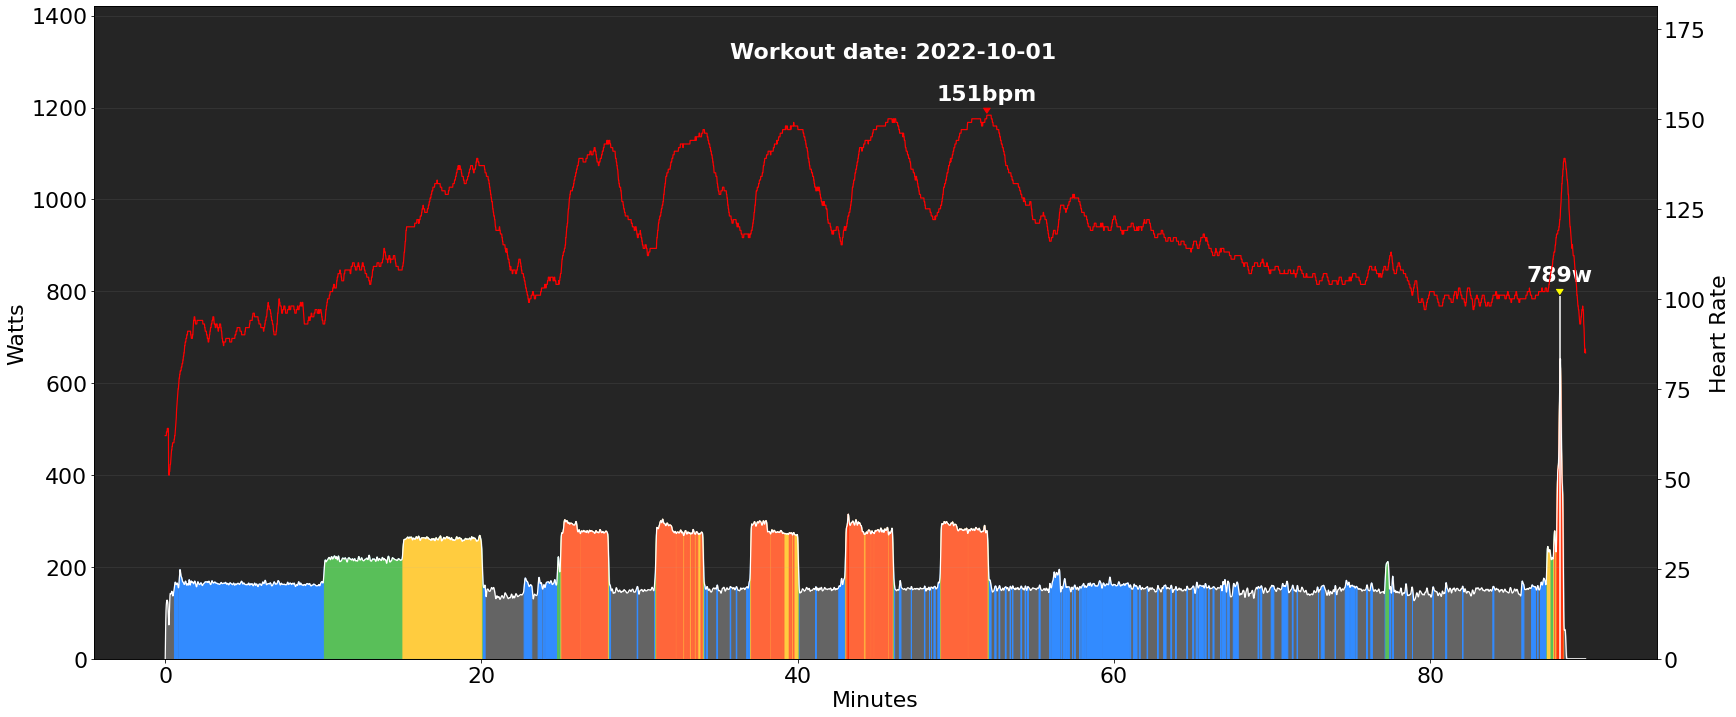

In [41]:
if ftp != None:
    figsize = (28, 12)    
    img, ax1 = plt.subplots(figsize=figsize)
    ax1.set_facecolor(color='#252525')
    ax1.set_xlabel("Minutes", fontsize=22.0)
    ax1.set_ylabel("Watts", fontsize=22.0)
    ax1.tick_params(labelsize=22.0)

    # This expands the top of the graph to 80% beyond max watts
    ax1.set_ylim(top=max(watts)*1.80)

    # logic for color under the graph based on % of FTP (thanks to Jonas Häggqvist for this code)
    ax1.grid(which='major', axis='y', alpha=0.1, linewidth=1)
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.00*ftp, color='#646464')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.60*ftp, color='#328bff')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.75*ftp, color='#59bf59')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.90*ftp, color='#ffcc3f')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 1.05*ftp, color='#ff663a')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 1.18*ftp, color='#ff340c')

    # Setting workout date annotation (thanks to Phil Daws for the code that helped me get started)
    # Note:  xy for the purposes of workout date label is set using 'data' for coordinates 
    xmin, xmax = ax1.get_xlim()
    ymin, ymax = ax1.get_ylim()
    xy = [xmax-(xmax*0.05), ymax-(ymax*0.05)]
    
    # Adding the workout date to the graph
    workout_date = Annotation(f'Workout date: {date_str}', xy=[xmax//2, ymax-(ymax*0.08)], 
                              ha='center', color='white', fontweight='bold', fontsize=22.0)
    ax1.add_artist(workout_date)
    
    # Plot smoothed power, line color, and thickness
    plt.plot(minutes, watts_smoothed, color='white', linewidth=1.25)
    
    # Annotate max power 
    max_power = Annotation(f'{max_watts}w', xy=(max_pwr_timestamp, max_watts), xytext=(0, 15), 
                           textcoords="offset pixels", ha='center', color='white', fontweight='bold', 
                           fontsize=22.0, arrowprops=dict(arrowstyle='wedge', color='yellow'))
    ax1.add_artist(max_power)
    
    plt.vlines(x=max_pwr_timestamp, ymin=0, ymax=max_watts, color='white', linewidth=1.5)
    
    
    # Instantiate second y axis for heart rate graph
    ax2 = ax1.twinx()
    ax2.set_ylabel("Heart Rate", fontsize=22.0)    
    ax2.set_ylim(top=max(hr)*1.20)
    ax2.tick_params(labelsize=22.0)
    
    # Plot heart rate
    ax2.plot(minutes, hr, color='red', linewidth=1.2)
    
    # Annotate max heart rate
    max_hr_annt = Annotation(f'{max_hr}bpm', xy=(max_hr_timestamp, max_hr), xytext=(0, 15), 
                           textcoords="offset pixels", ha='center', color='white', fontweight='bold', 
                           fontsize=22.0, arrowprops=dict(arrowstyle='wedge', color='red'))
    ax2.add_artist(max_hr_annt)
    
    plt.show()

else:
    print(f"\nThe graph cannot be drawn; no valid FTP was provided.")
    print(f"If you wish to try again, please have your FTP value ready and then reload this page.")
